In [1]:
!pip install opencv-python tensorflow matplotlib numpy


# Import Libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and Display the Medical Image

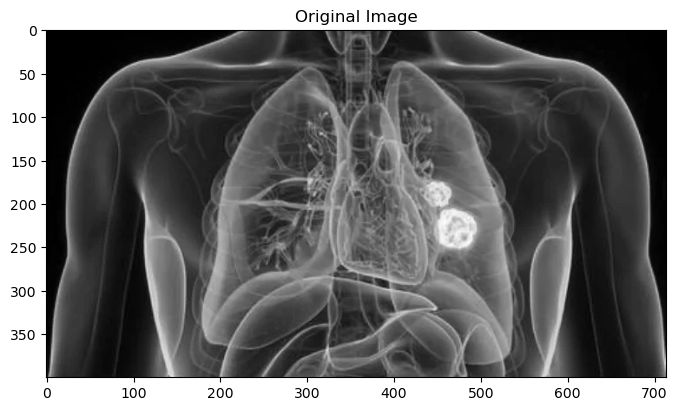

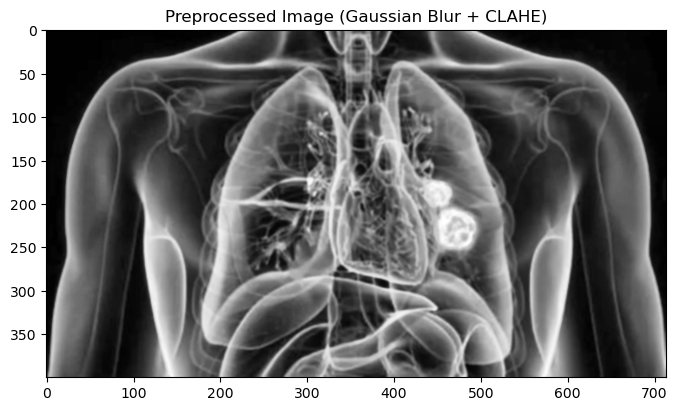

In [3]:
# Load the MRI image
image_path = "lung.webp"  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display the original image
plt.figure(figsize=(8, 6))
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.show()

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(blurred)

# Display the preprocessed image
plt.figure(figsize=(8, 6))
plt.title("Preprocessed Image (Gaussian Blur + CLAHE)")
plt.imshow(enhanced, cmap='gray')
plt.show()

# Segmentation with Otsu’s Thresholding

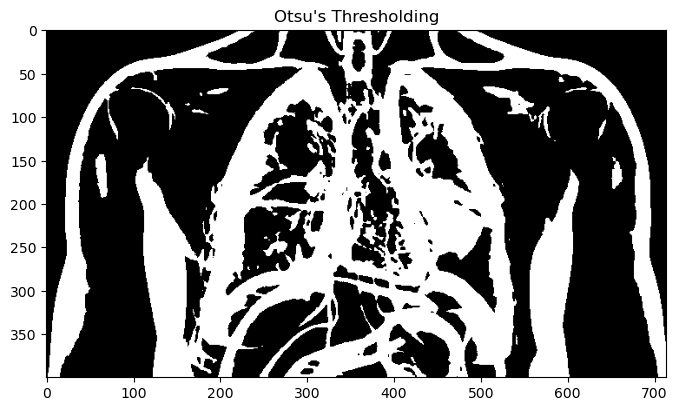

In [4]:
# Apply Otsu's thresholding
_, otsu_thresh = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the segmented image
plt.figure(figsize=(8, 6))
plt.title("Otsu's Thresholding")
plt.imshow(otsu_thresh, cmap='gray')
plt.show()


# Morphological Operations to Refine Segmentation

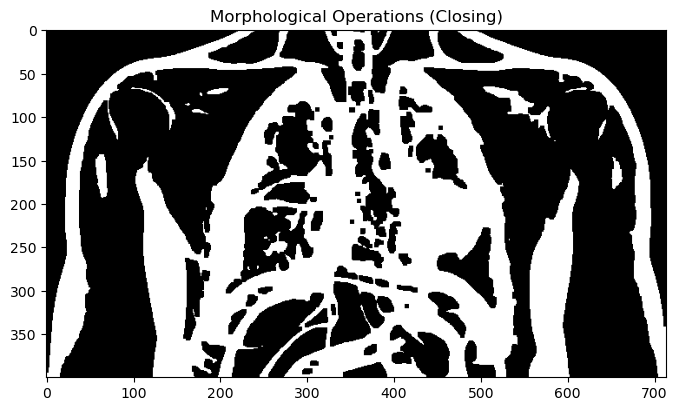

In [5]:
# Perform morphological operations (Closing to fill gaps)
kernel = np.ones((5, 5), np.uint8)
morphed = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE, kernel)

# Display the refined segmentation
plt.figure(figsize=(8, 6))
plt.title("Morphological Operations (Closing)")
plt.imshow(morphed, cmap='gray')
plt.show()


# Watershed Segmentation with Markers

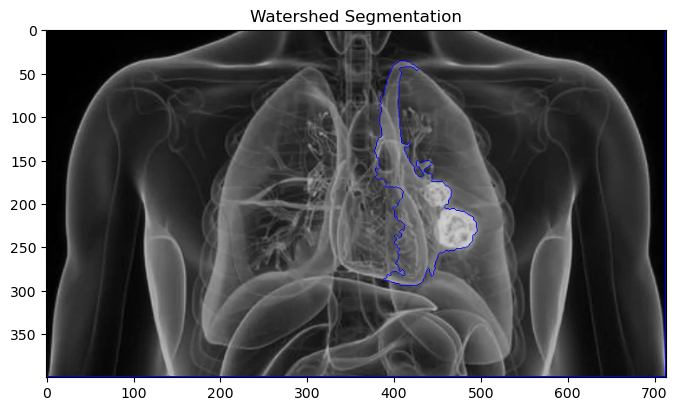

In [6]:
# Convert to 3-channel image for watershed
image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Compute the distance transform
dist_transform = cv2.distanceTransform(morphed, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Find sure background by dilating the morphologically processed image
sure_bg = cv2.dilate(morphed, kernel, iterations=3)

# Identify unknown regions (sure_bg - sure_fg)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Create markers for watershed
_, markers = cv2.connectedComponents(sure_fg)
markers += 1  # Add 1 to all markers to ensure the background is not labeled 0
markers[unknown == 255] = 0

# Apply watershed algorithm
cv2.watershed(image_color, markers)
image_color[markers == -1] = [255, 0, 0]  # Mark boundaries in red

# Display the watershed result
plt.figure(figsize=(8, 6))
plt.title("Watershed Segmentation")
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.show()


# Compare Thresholding vs. Watershed

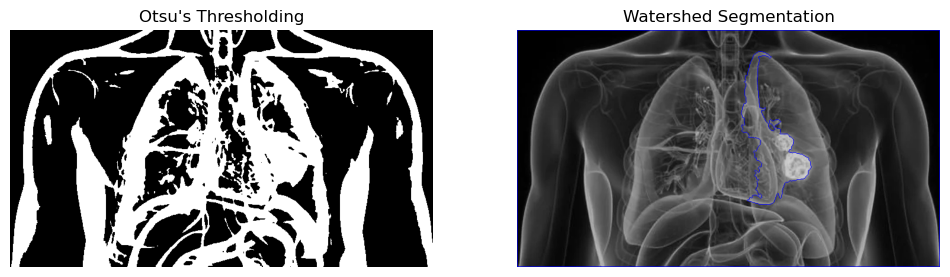

In [7]:
plt.figure(figsize=(12, 6))

# Otsu's Thresholding Image
plt.subplot(1, 2, 1)
plt.imshow(otsu_thresh, cmap='gray')  # Replace with actual image data
plt.title("Otsu's Thresholding")
plt.axis("off")

# Watershed Segmentation Image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.title("Watershed Segmentation")
plt.axis("off")

plt.show()

# 3D Visualization of Medical Images

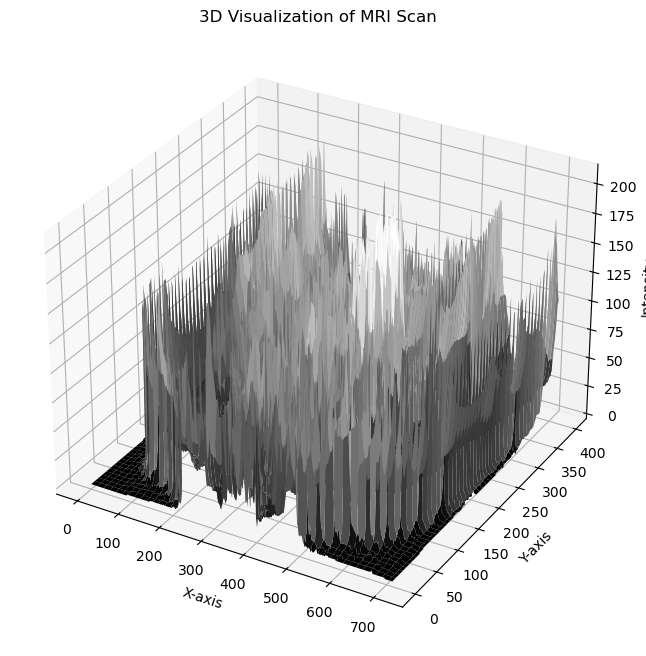

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate coordinates
X, Y = np.meshgrid(range(image.shape[1]), range(image.shape[0]))
Z = image

# Plot the surface
ax.plot_surface(X, Y, Z, cmap='gray', edgecolor='none')
ax.set_title("3D Visualization of MRI Scan")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Intensity")

plt.show()


# Connected Component Analysis

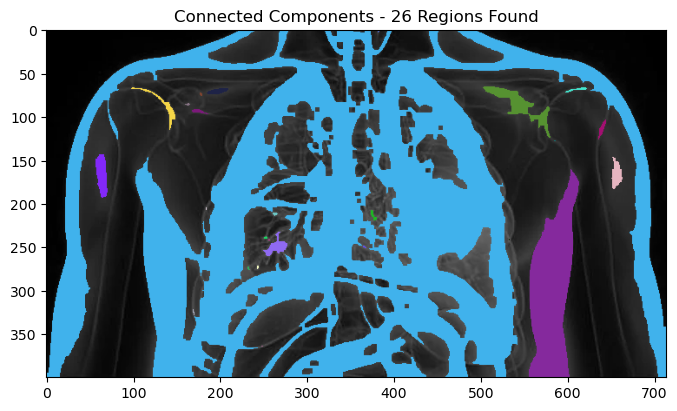

In [9]:
# Perform connected component analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(morphed, connectivity=8)

# Display the labeled regions
output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Assign different colors to each region
for i in range(1, num_labels):  # Skip the background (label 0)
    color = tuple(np.random.randint(0, 255, 3).tolist())
    output[labels == i] = color

plt.figure(figsize=(8, 6))
plt.title(f"Connected Components - {num_labels - 1} Regions Found")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.show()


# Region Properties

Number of connected components (excluding background): 26
Region 1: Area = 103973, Centroid = [340.31218682 218.60583036]
Region 2: Area = 7, Centroid = [382.42857143   1.28571429]
Region 3: Area = 245, Centroid = [135.04081633  88.77959184]
Region 4: Area = 1049, Centroid = [545.27454719  87.21067684]
Region 5: Area = 51, Centroid = [611.          69.09803922]
Region 6: Area = 119, Centroid = [197.15966387  71.09243697]
Region 7: Area = 10, Centroid = [178.   74.5]
Region 8: Area = 11, Centroid = [162.81818182  86.09090909]
Region 9: Area = 54, Centroid = [175.42592593  94.2037037 ]
Region 10: Area = 80, Centroid = [639.875 114.25 ]
Region 11: Area = 2, Centroid = [585.5 128. ]
Region 12: Area = 494, Centroid = [ 63.79959514 167.2611336 ]
Region 13: Area = 288, Centroid = [656.5        166.48958333]
Region 14: Area = 8117, Centroid = [582.81434027 297.52482444]
Region 15: Area = 3, Centroid = [184. 206.]
Region 16: Area = 38, Centroid = [376.47368421 213.92105263]
Region 17: Area = 16

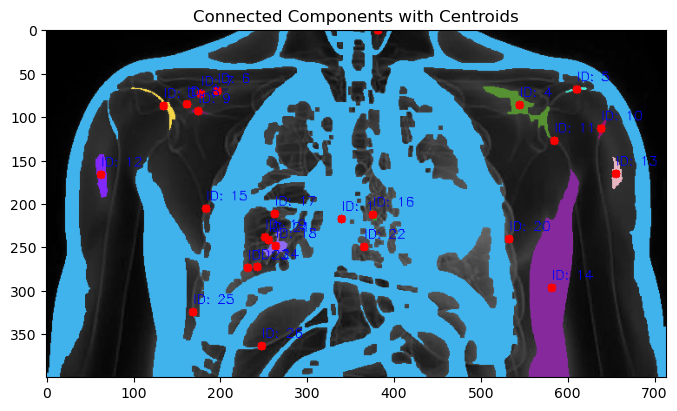

In [10]:
# Display properties of each region
print(f"Number of connected components (excluding background): {num_labels - 1}")

for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    centroid = centroids[i]
    print(f"Region {i}: Area = {area}, Centroid = {centroid}")

    # Draw the centroid on the image
    cv2.circle(output, (int(centroid[0]), int(centroid[1])), 5, (0, 0, 255), -1)
    cv2.putText(output, f"ID: {i}", (int(centroid[0]), int(centroid[1]) - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

plt.figure(figsize=(8, 6))
plt.title("Connected Components with Centroids")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.show()


# Overlay Results on the Original Image

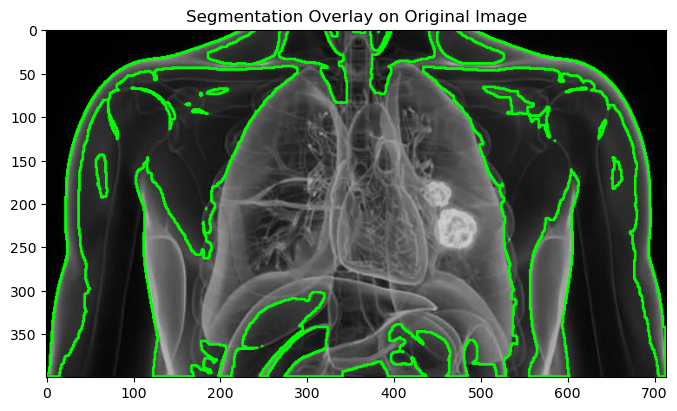

In [11]:
# Create a copy of the original image
overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw contours of the segmented regions
contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)  # Green contours

plt.figure(figsize=(8, 6))
plt.title("Segmentation Overlay on Original Image")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.show()


# Edge Detection with Canny

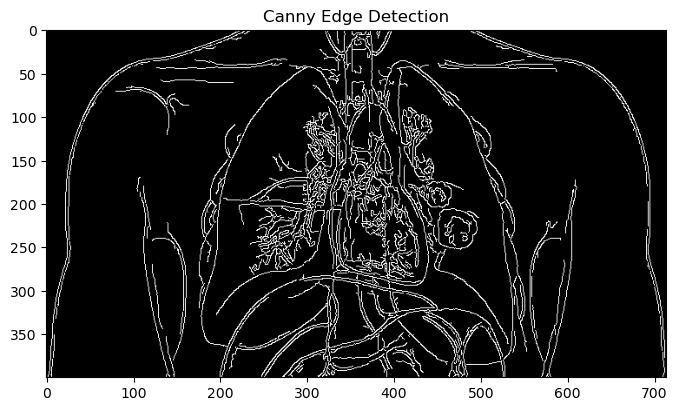

In [12]:
# Apply Canny Edge Detection
edges = cv2.Canny(image, threshold1=50, threshold2=150)

plt.figure(figsize=(8, 6))
plt.title("Canny Edge Detection")
plt.imshow(edges, cmap='gray')
plt.show()


# Histogram Equalization

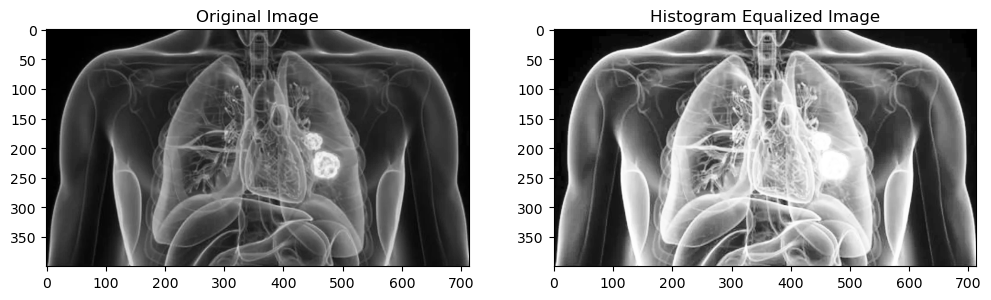

In [13]:
# Perform histogram equalization on a grayscale image
equalized = cv2.equalizeHist(image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Histogram Equalized Image")
plt.imshow(equalized, cmap='gray')

plt.show()


# Morphological Operations

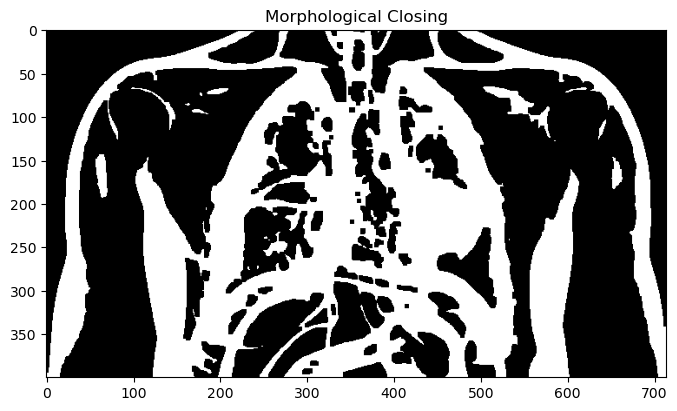

In [14]:
# Apply morphological closing to remove small holes in the segmented regions
kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(8, 6))
plt.title("Morphological Closing")
plt.imshow(closed, cmap='gray')
plt.show()
